# Modelling with local GP experts (Part I): A 1D case study
The main intended use case of ``GPSat`` is to model complex looking fields from a large set of data points, a situation commonly encountered in the geosciences, namely optimal interpolation (OI). The strategy that we adopted is quite simple: to model local chunks of data using different GPs and then gluing their predictions together.

In this tutorial notebook, we will see how this method performs compared to a single "global" GP. We note that ``GPSat`` has an automated API to carry out this whole workflow, which we will see in the second part of this tutorial. However for the sake of understanding, we will hard-code this method here.

In [1]:
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from GPSat.models.sklearn_models import sklearnGPRModel

2023-08-03 15:49:14.356855: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


First, we generate noisy data as follows:

\begin{align}
\tag{1}
y = \sin(1/X) + \epsilon, \quad \epsilon \sim \mathcal{N}(0, 0.05^2 I),
\end{align}

in the region $X \in [0.1, 0.6]$.

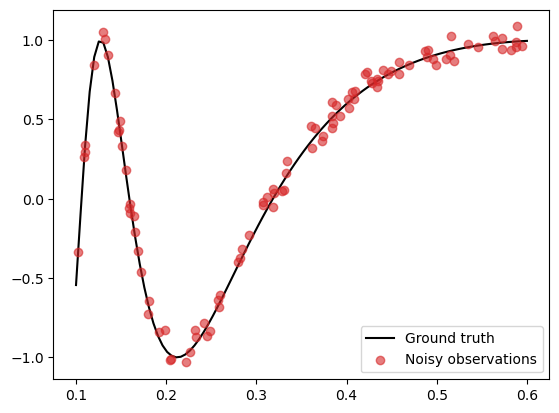

In [2]:
# Set random seed
np.random.seed(0)

# Generate data
N = 100
noise_std = 0.05

X_grid = np.linspace(0.1, 0.6, 100)
X = np.random.uniform(0.1, 0.6, (N,))
f = lambda x: np.sin(1/x)
epsilon = noise_std * np.random.randn(N)

y = f(X) + epsilon
f_truth = f(X_grid) # Ground truth

# Plot
plt.plot(X_grid, f_truth, 'k', zorder=1, label='Ground truth')
plt.scatter(X, y, color='C3', alpha=0.6, zorder=2, label='Noisy observations')
plt.legend()

This function is tricky to model well as the variability of the curve varies depending on where you are (shorter lengthscales near 0 and longer lengthscales near 1).

Let's first see how a standard GP fits on this data.

'__init__': 0.067 seconds
'optimise_parameters': 0.122 seconds
'predict': 0.002 seconds


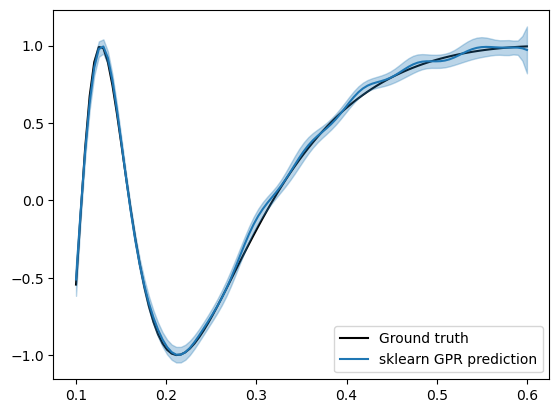

In [8]:
# Initialise sklearn GPR model
gpr = sklearnGPRModel(coords=X, obs=y, kernel='RBF', likelihood_variance=noise_std**2, verbose=False)

# Train model
_ = gpr.optimise_parameters()

# Predict on test locations
pred_dict = gpr.predict(X_grid[:,None])

# Extract mean and variance of predictions
f_mean = pred_dict['f*']
f_var = pred_dict['f*_var']
f_std = np.sqrt(f_var)

# Plot results
plt.plot(X_grid, f_truth, 'k', zorder=0, label='Ground truth')
plt.plot(X_grid, f_mean, color='C0', zorder=1, label='sklearn GPR prediction')
plt.fill_between(X_grid, f_mean-1.96*f_std, f_mean+1.96*f_std, color='C0', alpha=0.3)
plt.legend()

We see that the model fits quite well near 0.1, however as it approaches 0.6, we start to see some spurious fluctuations that does not exist in the ground truth field.

Checking the learned lengthscale,

In [6]:
print(f"Lengthscale: {gpr.get_lengthscales():.4f}")

Lengthscale: 0.0364


it is quite short, which explains the rapid fluctuations.

Let us also check the mean squared error and the log-likelihood loss from the ground truth field for future reference.

In [9]:
print(f"Mean squared error: {np.mean((f_truth - f_mean)**2):.4f}")
print(f"Mean log likelihood: {scipy.stats.norm.logpdf(f_truth, f_mean, f_std).mean():.4f}")

Mean squared error: 0.0005
Mean log likelihood: 2.3388


## Local GP experts
Next, let us consider a natural idea to solve this issue by fitting different GPs (called *local experts*) on different regions of the domain. For simplicity, we will use two GP experts: one to model the data for smaller values of $X$ and another to model the data for larger values of $X$.

We assign the following data to the two GPs (call it GP1 and GP2):

- GP1 gets assigned data points within the interval [0.1, 0.4] and makes predictions in the same region.
- GP2 gets assigned data points within the interval [0.3, 0.6] and makes predictions in the same region.

Note that we deliberately let the two regions overlap, which will be useful later.

In [12]:
# Data points assigned to GP1 and GP2
Data1 = np.array([[x, y] for (x, y) in zip(X, y) if x < 0.4])
Data2 = np.array([[x, y] for (x, y) in zip(X, y) if x > 0.3])

# Prediction points assigned to GP1 and GP2
X_test_1 = X_grid[X_grid < 0.4]
X_test_2 = X_grid[X_grid > 0.3]


By convention, we will associate each region ([0.1, 0.4] and [0.3, 0.6]) by their mid-points (0.25 and 0.45 respectively), and refer to them as the *local expert locations*.

The distance from the local expert location to the boundary of the region where data points are assigned is referred to as the *training radius*. In this case, we can check that our two experts both have a training radius of 0.15.

Likewise, the distance from the local expert location to the boundary of the region where prediction points are assigned is referred to as the *inference radius*. In our case, we have set the inference radius to be equal to the training radius.

In [13]:
# Set expert locations
xpert_loc_1 = 0.25
xpert_loc_2 = 0.45

# Set training and inference radii
training_radius = inference_radius = 0.15

Now we train GP1 and GP2 in their respective regions and make predictions.

In [14]:
# Train and predict with GP1
gp1 = sklearnGPRModel(coords=Data1[:,0], obs=Data1[:,1], kernel='RBF', likelihood_variance=noise_std**2, verbose=False)
_ = gp1.optimise_parameters()
pred_dict_1 = gp1.predict(X_test_1[:,None])
f_mean_1 = pred_dict_1['f*']
f_var_1 = pred_dict_1['f*_var']
f_std_1 = np.sqrt(f_var_1)

# Train and predict with GP2
gp2 = sklearnGPRModel(coords=Data2[:,0], obs=Data2[:,1], kernel='RBF', likelihood_variance=noise_std**2, verbose=False)
_ = gp2.optimise_parameters()
pred_dict_2 = gp2.predict(X_test_2[:,None])
f_mean_2 = pred_dict_2['f*']
f_var_2 = pred_dict_2['f*_var']
f_std_2 = np.sqrt(f_var_2)



'__init__': 0.031 seconds
'optimise_parameters': 0.122 seconds
'predict': 0.001 seconds
'__init__': 0.017 seconds
'optimise_parameters': 0.041 seconds
'predict': 0.000 seconds


Below, we plot the predictions from the two GPs over-layed on top of one another.

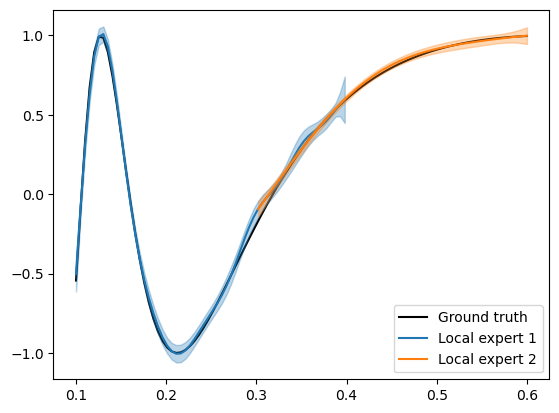

In [81]:
# Plot results
plt.plot(X_grid, f_truth, 'k', zorder=0, label='Ground truth')
plt.plot(X_test_1, f_mean_1, color='C0', zorder=1, label='Local expert 1')
plt.fill_between(X_test_1, f_mean_1-1.96*f_std_1, f_mean_1+1.96*f_std_1, color='C0', alpha=0.3)
plt.plot(X_test_2, f_mean_2, color='C1', zorder=1, label='Local expert 2')
plt.fill_between(X_test_2, f_mean_2-1.96*f_std_2, f_mean_2+1.96*f_std_2, color='C1', alpha=0.3)
plt.legend()

As expected, we find that GP1 fits the data with a shorter lengthscale and GP2 fits the data with a longer lengthscale.

In [28]:
print(f"Lengthscale of GP1: {gp1.get_lengthscales():.4f}")
print(f"Lengthscale of GP2: {gp2.get_lengthscales():.4f}")

Lengthscale of GP1: 0.0321
Lengthscale of GP2: 0.1632


We can now use the ``glue_local_predictions_1d()`` method from the ``GPSat.postprocessing`` module to glue the two predictions smoothly to yield a single prediction.

This is achieved by a gating mechanism, which considers a Gaussian-weighted average of the two predictions.

First, we record our results into a pandas dataframe as follows. This dataframe should have as columns (1) the prediction locations, (2) local expert locations, and (3) any results we wish to glue such as the predicted mean and variance.

In [29]:
from GPSat.postprocessing import glue_local_predictions_1d

# Prediction locations for GP1 + GP2
pred_locs = list(X_test_1) + list(X_test_2)

# Expert locations for GP1 + GP2
expert_locs = [xpert_loc_1 for _ in X_test_1] + [xpert_loc_2 for _ in X_test_2]

# Predictions from GP1 + GP2
f_mean = list(f_mean_1) + list(f_mean_2)
f_var = list(f_var_1) + list(f_var_2)

# Put these information together into a dataframe
results_df = pd.DataFrame({'pred_locs': pred_locs, 'xprt_locs': expert_locs, 'f_mean': f_mean, 'f_var': f_var})

print(results_df.head())
print(" "*20 + ":")
print(" "*20 + ":")
print(results_df.tail())

   pred_locs  xprt_locs    f_mean     f_var
0   0.100000       0.25 -0.501423  0.003268
1   0.105051       0.25 -0.080115  0.000920
2   0.110101       0.25  0.310646  0.000572
3   0.115152       0.25  0.635114  0.000698
4   0.120202       0.25  0.866515  0.000760
                    :
                    :
     pred_locs  xprt_locs    f_mean     f_var
115   0.579798       0.45  0.985532  0.000255
116   0.584848       0.45  0.988731  0.000312
117   0.589899       0.45  0.991786  0.000402
118   0.594949       0.45  0.994677  0.000536
119   0.600000       0.45  0.997378  0.000728


We can now glue local predictions by running ``glue_local_predictions_1d()``. This returns a dataframe containing the results of a single *glued prediction*.

In [24]:
# Glue predictions
glued_preds = glue_local_predictions_1d(preds_df = results_df,                  # The dataframe where results are stored
                                        pred_loc_col = 'pred_locs',             # The column in dataframe corresponding to the prediction locations
                                        xprt_loc_col = 'xprt_locs',             # The column in dataframe corresponding to the local expert locations
                                        vars_to_glue = ['f_mean', 'f_var'],     # The columns in dataframe corresponding to the predictions
                                        inference_radius = inference_radius)    # The inference radius (by passing a single float, it is assumed to be equal for both regions)

glued_preds.head()

,pred_locs,f_mean,f_var
0,0.100000,-0.501423,0.003268
1,0.105051,-0.080115,0.000920
2,0.110101,0.310646,0.000572
3,0.115152,0.635114,0.000698
4,0.120202,0.866515,0.000760


Finally we plot the results of this glued prediction.

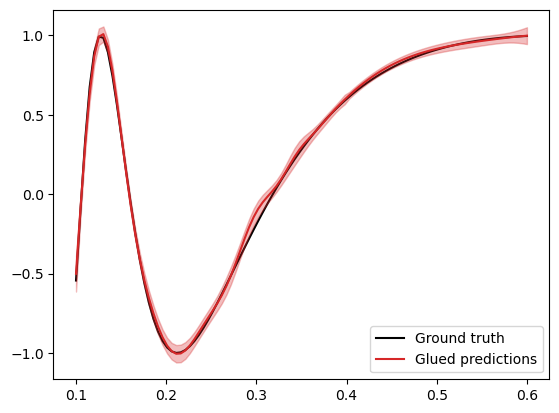

In [25]:
# Extract mean and variance of glued prediction
f_mean = glued_preds["f_mean"]
f_var = glued_preds["f_var"]
f_std = np.sqrt(f_var)
X_test = glued_preds['pred_locs']

# Plot results
plt.plot(X_grid, f_truth, 'k', zorder=0, label='Ground truth')
plt.plot(X_test, f_mean, color='C3', zorder=1, label='Glued predictions')
plt.fill_between(X_test, f_mean-1.96*f_std, f_mean+1.96*f_std, color='C3', alpha=0.3)
plt.legend()

The result of the glued prediction looks slightly better than our first attempt using a global GP. This improvement is also reflected in the metrics, with a slightly improved log-likelihood score:

In [26]:
print(f"Mean squared error: {np.mean((f_truth - f_mean)**2):.4f}")
print(f"Mean log likelihood: {scipy.stats.norm.logpdf(f_truth, f_mean, f_std).mean():.4f}")

Mean squared error: 0.0005
Mean log likelihood: 2.5734
